<a href="https://colab.research.google.com/github/kanumardi/kanu_mardi/blob/master/Awesome_ML_and_Text_Classification_Movie_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.18.0


In [67]:

"""IMDB sentiment classification dataset."""

import json

import numpy as np

from keras.src.api_export import keras_export
from keras.src.utils.file_utils import get_file
from keras.src.utils.python_utils import remove_long_seq


@keras_export("keras.datasets.imdb.load_data")
def load_data(
    path="imdb.npz",
    num_words=None,
    skip_top=0,
    maxlen=None,
    seed=113,
    start_char=1,
    oov_char=2,
    index_from=3,
    **kwargs,
):
    """Loads the [IMDB dataset](https://ai.stanford.edu/~amaas/data/sentiment/).

    This is a dataset of 25,000 movies reviews from IMDB, labeled by sentiment
    (positive/negative). Reviews have been preprocessed, and each review is
    encoded as a list of word indexes (integers).
    For convenience, words are indexed by overall frequency in the dataset,
    so that for instance the integer "3" encodes the 3rd most frequent word in
    the data. This allows for quick filtering operations such as:
    "only consider the top 10,000 most
    common words, but eliminate the top 20 most common words".

    As a convention, "0" does not stand for a specific word, but instead is used
    to encode the pad token.

    Args:
        path: where to cache the data (relative to `~/.keras/dataset`).
        num_words: integer or None. Words are
            ranked by how often they occur (in the training set) and only
            the `num_words` most frequent words are kept. Any less frequent word
            will appear as `oov_char` value in the sequence data. If None,
            all words are kept. Defaults to `None`.
        skip_top: skip the top N most frequently occurring words
            (which may not be informative). These words will appear as
            `oov_char` value in the dataset. When 0, no words are
            skipped. Defaults to `0`.
        maxlen: int or None. Maximum sequence length.
            Any longer sequence will be truncated. None, means no truncation.
            Defaults to `None`.
        seed: int. Seed for reproducible data shuffling.
        start_char: int. The start of a sequence will be marked with this
            character. 0 is usually the padding character. Defaults to `1`.
        oov_char: int. The out-of-vocabulary character.
            Words that were cut out because of the `num_words` or
            `skip_top` limits will be replaced with this character.
        index_from: int. Index actual words with this index and higher.

    Returns:
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.

    **`x_train`, `x_test`**: lists of sequences, which are lists of indexes
      (integers). If the num_words argument was specific, the maximum
      possible index value is `num_words - 1`. If the `maxlen` argument was
      specified, the largest possible sequence length is `maxlen`.

    **`y_train`, `y_test`**: lists of integer labels (1 or 0).

    **Note**: The 'out of vocabulary' character is only used for
    words that were present in the training set but are not included
    because they're not making the `num_words` cut here.
    Words that were not seen in the training set but are in the test set
    have simply been skipped.
    """
    origin_folder = (
        "https://storage.googleapis.com/tensorflow/tf-keras-datasets/"
    )
    path = get_file(
        fname=path,
        origin=origin_folder + "imdb.npz",
        file_hash=(  # noqa: E501
            "69664113be75683a8fe16e3ed0ab59fda8886cb3cd7ada244f7d9544e4676b9f"
        ),
    )
    with np.load(path, allow_pickle=True) as f:
        x_train, labels_train = f["x_train"], f["y_train"]
        x_test, labels_test = f["x_test"], f["y_test"]

    rng = np.random.RandomState(seed)
    indices = np.arange(len(x_train))
    rng.shuffle(indices)
    x_train = x_train[indices]
    labels_train = labels_train[indices]

    indices = np.arange(len(x_test))
    rng.shuffle(indices)
    x_test = x_test[indices]
    labels_test = labels_test[indices]

    if start_char is not None:
        x_train = [[start_char] + [w + index_from for w in x] for x in x_train]
        x_test = [[start_char] + [w + index_from for w in x] for x in x_test]
    elif index_from:
        x_train = [[w + index_from for w in x] for x in x_train]
        x_test = [[w + index_from for w in x] for x in x_test]
    else:
        x_train = [[w for w in x] for x in x_train]
        x_test = [[w for w in x] for x in x_test]

    if maxlen:
        x_train, labels_train = remove_long_seq(maxlen, x_train, labels_train)
        x_test, labels_test = remove_long_seq(maxlen, x_test, labels_test)
        if not x_train or not x_test:
            raise ValueError(
                "After filtering for sequences shorter than maxlen="
                f"{str(maxlen)}, no sequence was kept. Increase maxlen."
            )

    xs = x_train + x_test
    labels = np.concatenate([labels_train, labels_test])

    if not num_words:
        num_words = max(max(x) for x in xs)

    # by convention, use 2 as OOV word
    # reserve 'index_from' (=3 by default) characters:
    # 0 (padding), 1 (start), 2 (OOV)
    if oov_char is not None:
        xs = [
            [w if (skip_top <= w < num_words) else oov_char for w in x]
            for x in xs
        ]
    else:
        xs = [[w for w in x if skip_top <= w < num_words] for x in xs]

    idx = len(x_train)
    x_train, y_train = np.array(xs[:idx], dtype="object"), labels[:idx]
    x_test, y_test = np.array(xs[idx:], dtype="object"), labels[idx:]
    return (x_train, y_train), (x_test, y_test)


@keras_export("keras.datasets.imdb.get_word_index")
def get_word_index(path="imdb_word_index.json"):
    """Retrieves a dict mapping words to their index in the IMDB dataset.

    Args:
        path: where to cache the data (relative to `~/.keras/dataset`).

    Returns:
        The word index dictionary. Keys are word strings, values are their
        index.

    Example:

    ```python
    # Use the default parameters to keras.datasets.imdb.load_data
    start_char = 1
    oov_char = 2
    index_from = 3
    # Retrieve the training sequences.
    (x_train, _), _ = keras.datasets.imdb.load_data(
        start_char=start_char, oov_char=oov_char, index_from=index_from
    )
    # Retrieve the word index file mapping words to indices
    word_index = keras.datasets.imdb.get_word_index()
    # Reverse the word index to obtain a dict mapping indices to words
    # And add `index_from` to indices to sync with `x_train`
    inverted_word_index = dict(
        (i + index_from, word) for (word, i) in word_index.items()
    )
    # Update `inverted_word_index` to include `start_char` and `oov_char`
    inverted_word_index[start_char] = "[START]"
    inverted_word_index[oov_char] = "[OOV]"
    # Decode the first sequence in the dataset
    decoded_sequence = " ".join(inverted_word_index[i] for i in x_train[0])
    ```
    """
    origin_folder = (
        "https://storage.googleapis.com/tensorflow/tf-keras-datasets/"
    )
    path = get_file(
        fname=path,
        origin=origin_folder + "imdb_word_index.json",
        file_hash="bfafd718b763782e994055a2d397834f",
    )
    with open(path) as f:
        return json.load(f)


In [68]:
"""IMDB sentiment classification dataset."""

import json

import numpy as np

from keras.src.api_export import keras_export
from keras.src.utils.file_utils import get_file
from keras.src.utils.python_utils import remove_long_seq


@keras_export("keras.datasets.imdb.load_data")
def load_data(
    path="imdb.npz",
    num_words=None,
    skip_top=0,
    maxlen=None,
    seed=113,
    start_char=1,
    oov_char=2,
    index_from=3,
    **kwargs,
):
    """Loads the [IMDB dataset](https://ai.stanford.edu/~amaas/data/sentiment/).

    This is a dataset of 25,000 movies reviews from IMDB, labeled by sentiment
    (positive/negative). Reviews have been preprocessed, and each review is
    encoded as a list of word indexes (integers).
    For convenience, words are indexed by overall frequency in the dataset,
    so that for instance the integer "3" encodes the 3rd most frequent word in
    the data. This allows for quick filtering operations such as:
    "only consider the top 10,000 most
    common words, but eliminate the top 20 most common words".

    As a convention, "0" does not stand for a specific word, but instead is used
    to encode the pad token.

    Args:
        path: where to cache the data (relative to `~/.keras/dataset`).
        num_words: integer or None. Words are
            ranked by how often they occur (in the training set) and only
            the `num_words` most frequent words are kept. Any less frequent word
            will appear as `oov_char` value in the sequence data. If None,
            all words are kept. Defaults to `None`.
        skip_top: skip the top N most frequently occurring words
            (which may not be informative). These words will appear as
            `oov_char` value in the dataset. When 0, no words are
            skipped. Defaults to `0`.
        maxlen: int or None. Maximum sequence length.
            Any longer sequence will be truncated. None, means no truncation.
            Defaults to `None`.
        seed: int. Seed for reproducible data shuffling.
        start_char: int. The start of a sequence will be marked with this
            character. 0 is usually the padding character. Defaults to `1`.
        oov_char: int. The out-of-vocabulary character.
            Words that were cut out because of the `num_words` or
            `skip_top` limits will be replaced with this character.
        index_from: int. Index actual words with this index and higher.

    Returns:
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.

    **`x_train`, `x_test`**: lists of sequences, which are lists of indexes
      (integers). If the num_words argument was specific, the maximum
      possible index value is `num_words - 1`. If the `maxlen` argument was
      specified, the largest possible sequence length is `maxlen`.

    **`y_train`, `y_test`**: lists of integer labels (1 or 0).

    **Note**: The 'out of vocabulary' character is only used for
    words that were present in the training set but are not included
    because they're not making the `num_words` cut here.
    Words that were not seen in the training set but are in the test set
    have simply been skipped.
    """
    origin_folder = (
        "https://storage.googleapis.com/tensorflow/tf-keras-datasets/"
    )
    path = get_file(
        fname=path,
        origin=origin_folder + "imdb.npz",
        file_hash=(  # noqa: E501
            "69664113be75683a8fe16e3ed0ab59fda8886cb3cd7ada244f7d9544e4676b9f"
        ),
    )
    with np.load(path, allow_pickle=True) as f:
        x_train, labels_train = f["x_train"], f["y_train"]
        x_test, labels_test = f["x_test"], f["y_test"]

    rng = np.random.RandomState(seed)
    indices = np.arange(len(x_train))
    rng.shuffle(indices)
    x_train = x_train[indices]
    labels_train = labels_train[indices]

    indices = np.arange(len(x_test))
    rng.shuffle(indices)
    x_test = x_test[indices]
    labels_test = labels_test[indices]

    if start_char is not None:
        x_train = [[start_char] + [w + index_from for w in x] for x in x_train]
        x_test = [[start_char] + [w + index_from for w in x] for x in x_test]
    elif index_from:
        x_train = [[w + index_from for w in x] for x in x_train]
        x_test = [[w + index_from for w in x] for x in x_test]
    else:
        x_train = [[w for w in x] for x in x_train]
        x_test = [[w for w in x] for x in x_test]

    if maxlen:
        x_train, labels_train = remove_long_seq(maxlen, x_train, labels_train)
        x_test, labels_test = remove_long_seq(maxlen, x_test, labels_test)
        if not x_train or not x_test:
            raise ValueError(
                "After filtering for sequences shorter than maxlen="
                f"{str(maxlen)}, no sequence was kept. Increase maxlen."
            )

    xs = x_train + x_test
    labels = np.concatenate([labels_train, labels_test])

    if not num_words:
        num_words = max(max(x) for x in xs)

    # by convention, use 2 as OOV word
    # reserve 'index_from' (=3 by default) characters:
    # 0 (padding), 1 (start), 2 (OOV)
    if oov_char is not None:
        xs = [
            [w if (skip_top <= w < num_words) else oov_char for w in x]
            for x in xs
        ]
    else:
        xs = [[w for w in x if skip_top <= w < num_words] for x in xs]

    idx = len(x_train)
    x_train, y_train = np.array(xs[:idx], dtype="object"), labels[:idx]
    x_test, y_test = np.array(xs[idx:], dtype="object"), labels[idx:]
    return (x_train, y_train), (x_test, y_test)


@keras_export("keras.datasets.imdb.get_word_index")
def get_word_index(path="imdb_word_index.json"):
    """Retrieves a dict mapping words to their index in the IMDB dataset.

    Args:
        path: where to cache the data (relative to `~/.keras/dataset`).

    Returns:
        The word index dictionary. Keys are word strings, values are their
        index.

    Example:

    ```python
    # Use the default parameters to keras.datasets.imdb.load_data
    start_char = 1
    oov_char = 2
    index_from = 3
    # Retrieve the training sequences.
    (x_train, _), _ = keras.datasets.imdb.load_data(
        start_char=start_char, oov_char=oov_char, index_from=index_from
    )
    # Retrieve the word index file mapping words to indices
    word_index = keras.datasets.imdb.get_word_index()
    # Reverse the word index to obtain a dict mapping indices to words
    # And add `index_from` to indices to sync with `x_train`
    inverted_word_index = dict(
        (i + index_from, word) for (word, i) in word_index.items()
    )
    # Update `inverted_word_index` to include `start_char` and `oov_char`
    inverted_word_index[start_char] = "[START]"
    inverted_word_index[oov_char] = "[OOV]"
    # Decode the first sequence in the dataset
    decoded_sequence = " ".join(inverted_word_index[i] for i in x_train[0])
    ```
    """
    origin_folder = (
        "https://storage.googleapis.com/tensorflow/tf-keras-datasets/"
    )
    path = get_file(
        fname=path,
        origin=origin_folder + "imdb_word_index.json",
        file_hash="bfafd718b763782e994055a2d397834f",
    )
    with open(path) as f:
        return json.load(f)

In [69]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [70]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [71]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [72]:
len(train_data[0]), len(train_data[1])

(218, 189)

In [73]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [74]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [75]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [76]:
len(train_data[0]), len(train_data[1])

(256, 256)

In [77]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

In [78]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [79]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [80]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [81]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - acc: 0.5045 - loss: 0.6927 - val_acc: 0.6718 - val_loss: 0.6892
Epoch 2/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - acc: 0.6566 - loss: 0.6868 - val_acc: 0.6642 - val_loss: 0.6781
Epoch 3/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - acc: 0.6835 - loss: 0.6732 - val_acc: 0.6665 - val_loss: 0.6577
Epoch 4/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - acc: 0.7050 - loss: 0.6474 - val_acc: 0.7365 - val_loss: 0.6274
Epoch 5/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - acc: 0.7626 - loss: 0.6116 - val_acc: 0.7660 - val_loss: 0.5822
Epoch 6/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - acc: 0.7933 - loss: 0.5621 - val_acc: 0.8030 - val_loss: 0.5329
Epoch 7/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - acc: 0.8205 - loss: 0.5095 - val_acc: 0.8256 - val_loss: 0.4773
Epoch 8/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - acc: 0.8408 - loss: 0.4508 - val_acc: 0.8357 - val_loss: 0.4360
Epoch 9/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - acc: 0.8557

In [82]:
results = model.evaluate(test_data, test_labels)

print(results)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - acc: 0.8768 - loss: 0.3069
[0.31127220392227173, 0.8768399953842163]


In [83]:
history_dict = history.history
history_dict.keys()

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])

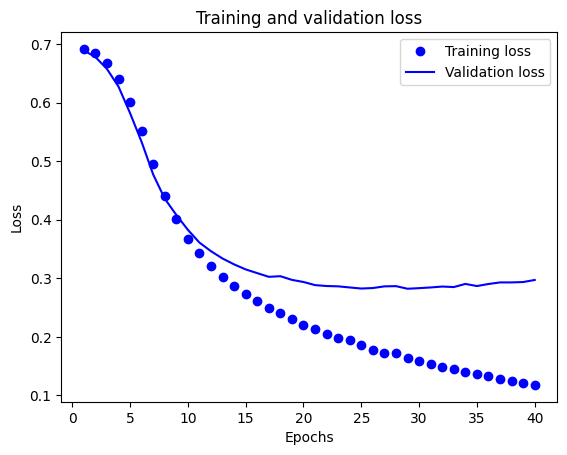

In [84]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

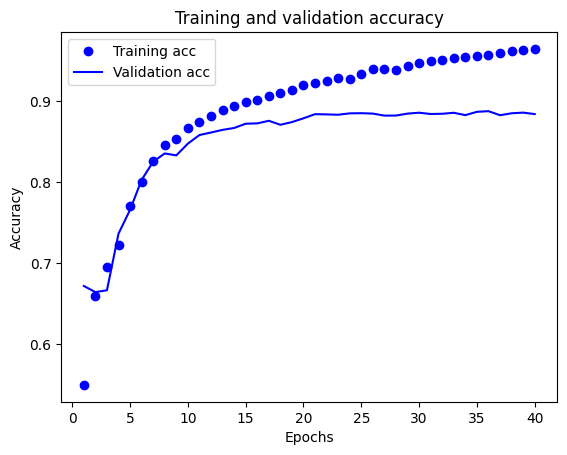

In [85]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**QA self learning chatbot using faiss sqlite nltk**

In [86]:
!pip install faiss-cpu

In [87]:
import nltk
import spacy
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import time
import sqlite3
import faiss
import string
import re
from collections import defaultdict
from textblob import Word, TextBlob

In [88]:
faq_dict = {
    "What is Artificial Intelligence (AI)?": "Artificial Intelligence refers to the simulation of human intelligence in machines that are programmed to think and learn. It encompasses tasks such as learning, reasoning, problem-solving, perception, and language understanding.",
    "How does AI work?": "AI systems work by processing large amounts of data, recognizing patterns, and making decisions based on statistical analysis. They utilize algorithms and models to perform tasks without explicit human instructions.",
    "What are the different types of AI?": "AI can be categorized into Narrow AI (designed for specific tasks), General AI (possessing human-like cognitive abilities), and Superintelligent AI (surpassing human intelligence). Currently, most AI applications are Narrow AI.",
    "What is Machine Learning?": "Machine Learning is a subset of AI that enables machines to learn from data and improve their performance over time without being explicitly programmed.",
    "What is Deep Learning?": "Deep Learning is a subset of Machine Learning that uses neural networks with many layers (deep neural networks) to analyze various factors of data. It is particularly effective in processing unstructured data like images and speech.",
    "What are Neural Networks?": "Neural Networks are algorithms inspired by the human brain's structure, designed to recognize patterns. They consist of interconnected nodes (neurons) that process data by assigning weights and biases.",
    "What is Natural Language Processing (NLP)?": "NLP is a branch of AI that focuses on the interaction between computers and humans through natural language. It enables machines to understand, interpret, and generate human language.",
    "What are the applications of AI?": "AI is used in various fields, including healthcare (diagnostics), finance (fraud detection), transportation (autonomous vehicles), customer service (chatbots), and more.",
    "What are the benefits of AI?": "AI can increase efficiency, reduce human error, automate repetitive tasks, and provide insights through data analysis, leading to better decision-making.",
    "What are the risks of AI?": "Potential risks include job displacement, ethical concerns, biases in decision-making, security vulnerabilities, and the possibility of unintended consequences.",
    "What is the future of AI?": "The future of AI involves advancements in machine learning algorithms, increased integration into various industries, and ongoing discussions about ethical and societal implications.",
    "Can AI replace human jobs?": "AI can automate certain tasks, potentially displacing some jobs. However, it also creates new opportunities and roles that require human skills.",
    "Is AI dangerous?": "AI poses risks if misused or poorly designed. Ensuring ethical guidelines and safety measures can mitigate potential dangers.",
    "How is AI used in business?": "Businesses use AI for data analysis, customer service automation, predictive analytics, and enhancing operational efficiency.",
    "What is the difference between AI and Machine Learning?": "AI is the broader concept of machines being able to carry out tasks in a way that we would consider 'smart,' while Machine Learning is a subset of AI that allows machines to learn from data.",
    "What is an AI algorithm?": "An AI algorithm is a set of rules and statistical techniques used by AI systems to learn from data and make decisions.",
    "What is the Turing Test?": "The Turing Test, proposed by Alan Turing, is a measure of a machine's ability to exhibit intelligent behavior indistinguishable from that of a human.",
    "What is a chatbot?": "A chatbot is an AI program designed to simulate conversation with human users, especially over the Internet.",
    "What is computer vision?": "Computer vision is an AI field that enables machines to interpret and process visual information from the world, such as images and videos.",
    "What is reinforcement learning?": "Reinforcement learning is a type of Machine Learning where an agent learns to make decisions by performing actions and receiving rewards or penalties.",
    "What is supervised learning?": "Supervised learning is a Machine Learning approach where models are trained on labeled datasets, meaning the input data is paired with the correct output.",
    "What is unsupervised learning?": "Unsupervised learning is a Machine Learning approach where models are trained on unlabeled data, and the system tries to learn patterns and structure from the input.",
    "What is semi-supervised learning?": "Semi-supervised learning is a Machine Learning approach that combines a small amount of labeled data with a large amount of unlabeled data during training.",
    "What is transfer learning?": "Transfer learning is a Machine Learning technique where a model developed for one task is reused as the starting point for a model on a second task.",
    "What is an AI model?": "An AI model is a mathematical representation of a real-world process, created by training algorithms on data to recognize patterns and make predictions.",
    "What is data mining?": "Data mining is the process of discovering patterns and knowledge from large amounts of data, often involving methods at the intersection of machine learning, statistics, and database systems.",
    "What is big data?": "Big data refers to extremely large datasets that may be analyzed computationally to reveal patterns, trends, and associations.",
    "What is the difference between AI and automation?": "Automation involves using technology to perform tasks without human intervention, often following predefined rules, whereas AI involves machines exhibiting intelligence and making decisions based on data.",
    "What is cognitive computing?": "Cognitive computing refers to systems that mimic human thought processes to solve complex problems, often involving self-learning through data mining and pattern recognition.",
    "What is the singularity in AI?": "The singularity refers to a hypothetical point in the future when AI surpasses human intelligence, leading to unforeseeable changes to human civilization.",
    "What is explainable AI?": "Explainable AI refers to methods and techniques in AI that make the results and workings of AI systems understandable to humans.",
    "What is ethical AI?": "Ethical AI involves designing and deploying AI systems in a manner that aligns with moral principles and values, ensuring fairness, transparency, and accountability.",
    "What is bias in AI?": "Bias in AI refers to systematic errors that result in unfair outcomes, often due to biased data or flawed algorithms.",
    "What is an AI-powered recommendation system?": "An AI-powered recommendation system suggests products, services, or information to users based on data analysis and predictive algorithms.",
    "What is the role of AI in cybersecurity?": "AI is used in cybersecurity to detect and respond to threats, analyze patterns, and enhance the overall security posture of organizations.",
    "What is the impact of AI on privacy?": "AI can impact privacy by processing large amounts of personal data, raising concerns about data protection and the potential for misuse.",
    "What is a neural network's activation function?": "An activation function in a neural network determines the output of a neuron, introducing non-linearities into the model, which allows it to learn complex patterns.",
    "What is overfitting in Machine Learning?": "Overfitting occurs when a Machine Learning model learns the training data too well, including noise and outliers, resulting in poor performance on new data.",
    "What is Computer Vision?": "Computer Vision is a field of artificial intelligence that enables computers and systems to interpret and process visual information from the world, such as images and videos, in a manner similar to human vision.",
    "How does Computer Vision differ from image processing?": "While image processing involves manipulating pixel values to enhance or transform images, Computer Vision focuses on understanding and interpreting the content of images to make decisions or extract information.",
    "What are common applications of Computer Vision?": "Common applications include facial recognition, autonomous vehicles, medical image analysis, surveillance, augmented reality, and quality inspection in manufacturing.",
    "What is the role of Machine Learning in Computer Vision?": "Machine Learning, especially deep learning, provides models and algorithms that enable Computer Vision systems to learn patterns and features from data, improving their ability to recognize and interpret visual information.",
    "What are Convolutional Neural Networks (CNNs)?": "CNNs are a class of deep neural networks specifically designed to process pixel data. They are widely used in Computer Vision tasks due to their ability to automatically and adaptively learn spatial hierarchies of features.",
    "What is image segmentation?": "Image segmentation is the process of partitioning an image into multiple segments or regions to simplify its representation and make it more meaningful for analysis.",
    "What is object detection?": "Object detection involves identifying and locating objects within an image or video. It provides both the classification and the position of objects.",
    "What is the difference between object detection and object recognition?": "Object recognition identifies what an object is, while object detection identifies what and where an object is within an image or scene.",
    "What is feature extraction in Computer Vision?": "Feature extraction involves identifying and isolating various desired portions or shapes (features) of an image to simplify the analysis of complex data.",
    "What are some popular Computer Vision libraries?": "Popular libraries include OpenCV, TensorFlow, Keras, PyTorch, and MATLAB's Image Processing Toolbox.",
    "What is the importance of datasets in Computer Vision?": "Datasets are crucial for training and evaluating Computer Vision models. High-quality, diverse datasets enable models to learn effectively and generalize to new data.",
    "What challenges does Computer Vision face?": "Challenges include varying lighting conditions, occlusions, viewpoint variations, real-time processing requirements, and the need for large annotated datasets.",
    "How has artificial intelligence (AI) changed Computer Vision?": "AI, particularly deep learning, has significantly improved the accuracy and capabilities of Computer Vision systems by enabling automatic feature learning from large datasets.",
    "What is the role of Computer Vision in autonomous vehicles?": "Computer Vision enables autonomous vehicles to perceive and interpret their surroundings, including detecting obstacles, recognizing traffic signs, and understanding lane markings.",
    "What is the difference between Computer Vision and image processing?": "Image processing focuses on enhancing or manipulating images, while Computer Vision aims to understand and interpret the content of images for decision-making.",
    "What is the significance of edge detection in Computer Vision?": "Edge detection is used to identify the boundaries within images, which is essential for object detection, recognition, and segmentation tasks.",
    "What is the role of Computer Vision in healthcare?": "In healthcare, Computer Vision assists in medical imaging analysis, such as detecting tumors, monitoring patient health, and aiding in diagnostics.",
    "What is the impact of Computer Vision on retail?": "Computer Vision enhances retail by enabling applications like automated checkout systems, customer behavior analysis, and inventory management.",
    "What is the role of Computer Vision in agriculture?": "In agriculture, Computer Vision is used for crop monitoring, disease detection, yield estimation, and precision farming practices.",
    "What is the significance of color space in Computer Vision?": "Color space represents the range of colors in an image. Understanding different color spaces (RGB, HSV, etc.) is important for various image processing tasks.",
    "What is the role of Computer Vision in security and surveillance?": "Computer Vision enables automated monitoring, anomaly detection, facial recognition, and activity analysis in security and surveillance systems.",
    "What is the importance of image annotation in Computer Vision?": "Image annotation involves labeling images with metadata, which is crucial for training supervised learning models in tasks like object detection and segmentation.",
    "What is the role of Computer Vision in sports analytics?": "In sports analytics, Computer Vision is used to track player movements, analyze game strategies, and enhance broadcasting with augmented reality.",
    "What is the significance of depth perception in Computer Vision?": "Depth perception allows Computer Vision systems to understand the three-dimensional structure of a scene, which is important for applications like 3D modeling and navigation.",
    "What is the role of Computer Vision in robotics?": "Computer Vision enables robots to perceive their environment, recognize objects, and perform tasks autonomously in dynamic settings.",
    "What is the impact of Computer Vision on manufacturing?": "In manufacturing, Computer Vision is used for quality control, defect detection, and automation of assembly line processes.",
    "What is the significance of optical character recognition (OCR) in Computer Vision?": "OCR is a technology that converts different types of documents, such as scanned paper documents or PDFs, into editable and searchable data.",
    "What is the role of Computer Vision in augmented reality (AR)?": "Computer Vision enables AR systems to understand and interact with the real world by recognizing and tracking objects and environments.",
    "What is the significance of image stitching in Computer Vision?": "Image stitching involves combining multiple images to produce a panorama or a high-resolution image, which is useful in fields like photography and mapping.",
    "What is the role of Computer Vision in environmental monitoring?": "Computer Vision assists in monitoring environmental changes, detecting pollution levels, and assessing disaster impacts through image and video analysis.",
    "What is the significance of facial recognition in Computer Vision?": "Facial recognition is used for identifying or verifying individuals based on their facial features, with applications in security, authentication, and social media.",
    "What is the role of Computer Vision in education?": "In education, Computer Vision can be used for interactive learning experiences, student engagement analysis, and automated grading systems.",
    "What is the significance of image compression in Computer Vision?": "Image compression reduces the file size of images, which is important for efficient storage and transmission without significant loss of quality.",
    "What is the role of Computer Vision in entertainment?": "Computer Vision enhances entertainment through applications like motion capture, special effects, and content recommendation systems.",
    "What is the significance of gesture recognition in Computer Vision?": "Gesture recognition allows computers to interpret human gestures, enabling intuitive human-computer interaction in applications like gaming and virtual reality.",
    "What is the role of Computer Vision in transportation?": "In transportation, Computer Vision is used for traffic monitoring, license plate recognition, and enhancing driver assistance systems.",
    "What is the significance of pattern recognition in Computer Vision?": "Pattern recognition involves identifying regularities in data, which is fundamental for tasks like image classification and object detection.",
    "What is the role of Computer Vision in archaeology?": "Computer Vision aids in archaeological research by analyzing site images, reconstructing artifacts, and preserving cultural heritage through digital means.",
    "What is Deep Learning?": "Deep Learning is a subset of machine learning that uses multilayered neural networks to simulate the complex decision-making power of the human brain. It enables systems to learn from vast amounts of data.",
    "How does Deep Learning differ from traditional Machine Learning?": "While traditional machine learning relies on manual feature extraction, deep learning automatically discovers representations from data, making it particularly effective for unstructured data like images and text.",
    "What are neural networks?": "Neural networks are computational models inspired by the human brain, consisting of interconnected units (neurons) that process information using dynamic state responses to external inputs.",
    "What is a perceptron?": "A perceptron is the simplest type of artificial neural network, consisting of a single neuron with adjustable weights and a threshold activation function.",
    "What are activation functions?": "Activation functions introduce non-linearity into the neural network, allowing it to learn complex patterns. Common examples include sigmoid, tanh, and ReLU functions.",
    "What is backpropagation?": "Backpropagation is a training algorithm for neural networks that calculates the gradient of the loss function and adjusts the weights to minimize the error.",
    "What is a convolutional neural network (CNN)?": "A CNN is a type of deep neural network primarily used for processing structured grid data like images. It employs convolutional layers to automatically and adaptively learn spatial hierarchies of features.",
    "What is a recurrent neural network (RNN)?": "An RNN is a class of neural networks where connections form cycles, allowing information to persist. They are particularly effective for sequential data like time series or natural language.",
    "What is overfitting in deep learning?": "Overfitting occurs when a model learns not only the underlying patterns in the training data but also the noise, leading to poor performance on unseen data.",
    "How can overfitting be prevented?": "Techniques to prevent overfitting include regularization methods (like L1 and L2), dropout, early stopping, and using more training data.",
    "What is dropout in neural networks?": "Dropout is a regularization technique where, during training, randomly selected neurons are ignored (dropped out), forcing the network to learn more robust features.",
    "What is a learning rate?": "The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated.",
    "What is batch normalization?": "Batch normalization is a technique to improve the training of deep neural networks by normalizing the inputs of each layer to have a consistent distribution, which can lead to faster convergence.",
    "What is a loss function?": "A loss function measures how well the model's predictions match the actual data. It guides the optimization process during training.",
    "What is an epoch in deep learning?": "An epoch refers to one complete pass through the entire training dataset during the training process.",
    "What is meant by transfer learning?": "Transfer learning involves leveraging a pre-trained model on a new, but related, problem, allowing for faster training and often improved performance.",
    "What is transfer learning?": "Transfer learning involves leveraging a pre-trained model on a new, but related, problem, allowing for faster training and often improved performance.",
    "What are autoencoders?": "Autoencoders are neural networks designed to learn efficient codings of input data by training the network to ignore noise and reconstruct the input data.",
    "What is reinforcement learning?": "Reinforcement learning is a type of machine learning where an agent learns to make decisions by performing actions and receiving feedback in the form of rewards or penalties.",
    "What is unsupervised learning?": "Unsupervised learning involves modeling the underlying structure of data without labeled responses, often for clustering or dimensionality reduction.",
    "What is supervised learning?": "Supervised learning involves learning a function that maps an input to an output based on example input-output pairs, using labeled training data.",
    "What is semi-supervised learning?": "Semi-supervised learning combines both labeled and unlabeled data during training, useful when labeled data is scarce.",
    "What is a generative adversarial network (GAN)?": "A GAN is a class of neural networks where two networks, a generator and a discriminator, compete against each other, leading to the generation of new, synthetic data samples.",
    "What is the vanishing gradient problem?": "The vanishing gradient problem occurs when gradients become too small during backpropagation, hindering the effective training of deep networks.",
    "What is the exploding gradient problem?": "The exploding gradient problem occurs when gradients become too large during backpropagation, leading to unstable training processes.",
    "What is a long short-term memory (LSTM) network?": "An LSTM is a type of RNN designed to overcome the vanishing gradient problem by maintaining long-term dependencies, making it effective for sequential data.",
    "What is a gated recurrent unit (GRU)?": "A GRU is a type of RNN similar to LSTM but with a simplified architecture, often leading to faster training while maintaining performance.",
    "What is a softmax function?": "The softmax function converts a vector of values into a probability distribution, commonly used in the output layer of classification models.",
    "What is a Boltzmann machine?": "A Boltzmann machine is a type of stochastic recurrent neural network capable of learning internal representations and solving combinatorial optimization problems.",
    "What is a restricted Boltzmann machine (RBM)?": "An RBM is a simplified version of a Boltzmann machine with a bipartite structure, commonly used for dimensionality reduction and collaborative filtering.",
    "What is a deep belief network (DBN)?": "A DBN is a stack of RBMs where each layer learns to represent the features detected in the previous layer, useful for unsupervised learning tasks.",
    "What is a variational autoencoder (VAE)?": "A VAE is a type of autoencoder that learns a probabilistic representation of the input data, allowing for the generation of new data samples.",
    "What is an embedding in deep learning?": "An embedding is a learned representation of data, often used to convert categorical data into continuous vectors for use in machine learning models.",
    "What is the role of GPUs in deep learning?": "GPUs accelerate deep learning computations by parallelizing operations, significantly reducing training times for large models.",
    "What is model hyperparameter tuning?": "Hyperparameter tuning involves selecting the optimal set of hyperparameters for a learning algorithm to improve model performance.",
    "What is cross-validation?": "Cross-validation is a technique for assessing how a model generalizes to an independent dataset, commonly used to prevent overfitting.",
    "What is data augmentation?": "Data augmentation involves creating modified versions of the original data to increase the diversity of the training set, improving model robustness.",
    "What is a learning rate scheduler?": "A learning rate scheduler adjusts the learning rate during training, often to improve convergence and performance.",
    "What is a weight initialization technique?": "Weight initialization techniques set the initial values of weights in a neural network, impacting the convergence and performance of the model.",
    "Why is it called the Internet of Things?": "It's called the Internet of Things because it extends internet connectivity beyond traditional devices like computers and smartphones to a diverse range of objects and environments.",
    "What is an IoT solution?": "An IoT solution is a combination of devices or other data sources, outfitted with sensors and internet-connected hardware, to securely report information back to an IoT platform.",
    "What is an IoT Proof of Concept (PoC)?": "An IoT PoC is a demonstration to validate the feasibility and potential of an IoT solution before full-scale implementation.",
    "What is an IoT cloud platform?": "An IoT cloud platform is a suite of cloud-based services that enables the development, deployment, and management of IoT applications and devices.",
    "What is AWS IoT Core?": "AWS IoT Core is a managed cloud service that allows connected devices to interact securely with cloud applications and other devices.",
    "How does AWS IoT Core work?": "AWS IoT Core works by providing secure communication and data processing between IoT devices and the AWS cloud, enabling real-time data collection and analysis.",
    "What is the difference between IoT and M2M?": "While both IoT and Machine-to-Machine (M2M) involve devices communicating, IoT typically refers to a broader network of connected devices using IP-based communication, whereas M2M often involves direct communication between devices using non-IP protocols.",
    "What are common applications of IoT?": "Common applications include smart homes, wearable health monitors, smart cities, industrial automation, and connected vehicles.",
    "What are the security concerns with IoT?": "Security concerns include data privacy, unauthorized access, device tampering, and ensuring secure communication channels.",
    "How is data collected in IoT?": "Data is collected through sensors embedded in IoT devices, which gather information from their environment and transmit it for processing.",
    "What is edge computing in IoT?": "Edge computing refers to processing data near the source of data generation (i.e., IoT devices) rather than relying solely on centralized cloud servers, reducing latency and bandwidth use.",
    "What is the role of AI in IoT?": "AI enables IoT systems to analyze large volumes of data, make predictions, and automate responses, enhancing decision-making and operational efficiency.",
    "How do IoT devices communicate?": "IoT devices communicate using various protocols such as MQTT, HTTP, CoAP, and through connectivity options like Wi-Fi, Bluetooth, Zigbee, and cellular networks.",
    "What is an IoT gateway?": "An IoT gateway is a physical device or software program that serves as the connection point between IoT devices and the cloud, facilitating data flow between them.",
    "What are the challenges in implementing IoT?": "Challenges include ensuring interoperability, managing data security, handling large data volumes, and providing reliable connectivity.",
    "What is the importance of standardization in IoT?": "Standardization ensures compatibility and interoperability between different IoT devices and systems, facilitating seamless integration and communication.",
    "How does IoT impact daily life?": "IoT impacts daily life by enabling smart home automation, improving healthcare monitoring, enhancing energy efficiency, and providing real-time information through connected devices.",
    "What is the future of IoT?": "The future of IoT includes increased device connectivity, advancements in AI integration, enhanced security measures, and broader adoption across various industries.",
    "What is an IoT ecosystem?": "An IoT ecosystem comprises all the components that enable IoT solutions, including devices, networks, cloud platforms, applications, and users.",
    "How does IoT contribute to smart cities?": "IoT contributes to smart cities by enabling intelligent traffic management, efficient energy usage, enhanced public safety, and improved urban planning through data-driven insights.",
    "What are IoT sensors?": "IoT sensors are devices that detect and measure physical properties from the environment, such as temperature, humidity, motion, and transmit this data for analysis.",
    "What is the role of big data in IoT?": "Big data technologies process and analyze the vast amounts of data generated by IoT devices, uncovering patterns, trends, and insights to inform decision-making.",
    "How do IoT devices handle power consumption?": "IoT devices handle power consumption through energy-efficient hardware design, low-power communication protocols, and power management strategies to extend battery life.",
    "What is the significance of IPv6 in IoT?": "IPv6 provides a larger address space, essential for accommodating the vast number of IoT devices connecting to the internet.",
    "How does IoT integrate with existing IT infrastructure?": "IoT integrates with existing IT infrastructure through APIs, middleware, and compatible communication protocols, allowing seamless data exchange and system interoperability.",
    "What is the impact of IoT on supply chain management?": "IoT impacts supply chain management by providing real-time tracking of goods, optimizing inventory levels, improving logistics, and enhancing transparency.",
    "What are wearable IoT devices?": "Wearable IoT devices are smart electronic devices worn on the body, such as fitness trackers and smartwatches, that collect and transmit data related to health and activity.",
    "How is IoT used in agriculture?": "IoT is used in agriculture through precision farming techniques, utilizing sensors and data analytics to monitor soil conditions, crop health, and optimize resource usage.",
    "What is the role of blockchain in IoT?": "Blockchain provides a secure and transparent method for recording transactions and data exchanges between IoT devices, enhancing security and trust.",
    "How do IoT devices update their firmware?": "IoT devices update their firmware through over-the-air (OTA) updates, allowing remote deployment of new software versions to fix bugs or add features.",
    "What is the significance of data analytics in IoT?": "Data analytics in IoT enables the extraction of meaningful insights from the vast data generated by devices, supporting informed decision-making and predictive analysis.",
    "How does IoT impact energy management?": "IoT impacts energy management by enabling smart grids, real-time monitoring of energy consumption, and automation of energy-saving measures.",
    "What are the ethical considerations in IoT?": "Ethical considerations include data privacy, consent for data collection, surveillance concerns, and ensuring equitable access to IoT technologies.",
    "How does IoT support remote monitoring?": "IoT supports remote monitoring by allowing devices to transmit data over the internet, enabling users to monitor and control systems from distant locations.",
    "What is the role of machine learning in IoT?": "Machine learning in IoT involves analyzing data patterns to make predictions, detect anomalies, and automate decision-making processes.",
    "What is Natural Language Processing (NLP)?": "Natural Language Processing (NLP) is a subfield of artificial intelligence that focuses on the interaction between computers and human languages, enabling machines to understand, interpret, and generate human language.",
    "What are the main applications of NLP?": "NLP is used in various applications including sentiment analysis, machine translation, chatbots, speech recognition, text summarization, and information extraction.",
    "What is tokenization in NLP?": "Tokenization is the process of breaking down text into smaller units, such as words or sentences, to facilitate analysis.",
    "What is the difference between stemming and lemmatization?": "Stemming reduces words to their root form by removing suffixes, while lemmatization reduces words to their base or dictionary form, considering the context.",
    "What is sentiment analysis?": "Sentiment analysis is the process of determining the emotional tone or attitude expressed in a piece of text, often categorized as positive, negative, or neutral.",
    "What are stop words in NLP?": "Stop words are common words like 'and', 'the', and 'is' that are often removed from text during preprocessing because they carry little meaningful information.",
    "What is part-of-speech tagging?": "Part-of-speech tagging involves labeling words in a text with their corresponding part of speech, such as noun, verb, adjective, etc.",
    "What is named entity recognition (NER)?": "Named Entity Recognition is the process of identifying and classifying proper nouns in text, such as names of people, organizations, locations, dates, and other specific terms.",
    "What is the Bag of Words model?": "The Bag of Words model represents text data by counting the frequency of words, disregarding grammar and word order.",
    "What is TF-IDF?": "Term Frequency-Inverse Document Frequency (TF-IDF) is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents.",
    "What is word embedding?": "Word embedding is a technique where words are represented as dense vectors in a continuous vector space, capturing semantic relationships between words.",
    "What is the difference between NLP and NLU?": "Natural Language Processing (NLP) encompasses the entire process of analyzing and generating human language, while Natural Language Understanding (NLU) focuses specifically on comprehending the meaning and intent behind the text.",
    "What are n-grams in NLP?": "N-grams are contiguous sequences of n items (words or characters) from a given text, used to analyze the context and predict the next item in sequences.",
    "What is a language model?": "A language model is a probabilistic model that predicts the likelihood of a sequence of words, aiding in tasks like speech recognition and text generation.",
    "What is the role of machine learning in NLP?": "Machine learning enables NLP systems to learn patterns and make predictions from data, improving tasks like classification, translation, and summarization.",
    "What are some common NLP libraries?": "Popular NLP libraries include NLTK, spaCy, Gensim, and Transformers.",
    "What is the difference between rule-based and statistical NLP?": "Rule-based NLP relies on handcrafted linguistic rules, while statistical NLP uses probabilistic models trained on large datasets to learn patterns.",
    "What is transfer learning in NLP?": "Transfer learning involves pre-training a model on a large corpus and fine-tuning it on a specific task, improving performance with less data.",
    "What is the importance of context in NLP?": "Context helps disambiguate words with multiple meanings and improves the accuracy of language models by considering surrounding words and sentences.",
    "What are some challenges in NLP?": "Challenges include handling ambiguity, understanding context, managing diverse languages and dialects, and processing idiomatic expressions.",
    "What is coreference resolution?": "Coreference resolution is the task of identifying expressions that refer to the same entity in a text, such as pronouns and their antecedents.",
    "What is the difference between syntactic and semantic analysis?": "Syntactic analysis focuses on the grammatical structure of sentences, while semantic analysis aims to understand the meaning conveyed by the text.",
    "What is a corpus in NLP?": "A corpus is a large and structured set of texts used for training and evaluating NLP models.",
    "What is the role of deep learning in NLP?": "Deep learning models, such as neural networks, have significantly improved NLP tasks by capturing complex patterns and representations in language data.",
    "What is the difference between speech recognition and NLP?": "Speech recognition converts spoken language into text, while NLP processes and analyzes the text to derive meaning and insights.",
    "What is text summarization?": "Text summarization is the process of creating a concise and coherent summary of a longer text document.",
    "What is information retrieval in NLP?": "Information retrieval involves finding relevant documents or pieces of information from a large repository based on user queries.",
    "What is topic modeling?": "Topic modeling is an unsupervised learning technique used to identify themes or topics within a collection of documents.",
    "What is the role of attention mechanisms in NLP?": "Attention mechanisms allow models to focus on relevant parts of the input sequence, improving performance in tasks like translation and summarization.",
    "What is the difference between supervised and unsupervised learning in NLP?": "Supervised learning uses labeled data to train models, while unsupervised learning finds patterns in unlabeled data.",
    "What is the significance of word sense disambiguation?": "Word sense disambiguation is the process of determining the correct meaning of a word in context, which is crucial for accurate language understanding.",
    "What is a chatbot?": "A chatbot is a software application that uses NLP to simulate human-like conversations with users.",
    "What is the role of reinforcement learning in NLP?": "Reinforcement learning can be used to optimize dialogue systems and other interactive NLP applications by learning from user feedback.",
    "What is the difference between online and batch learning in NLP?": "Online learning updates the model incrementally as new data arrives, while batch learning updates the model using the entire dataset at once.",
    "What is the importance of evaluation metrics in NLP?": "Evaluation metrics, such as accuracy, precision, recall, and F1-score, are essential for assessing the performance of NLP models.",
    "What is the role of syntax trees in NLP?": "Syntax trees represent the grammatical structure of sentences, aiding in parsing and understanding complex sentence constructions.",
    "What is zero-shot learning in NLP?": "Zero-shot learning enables models to handle tasks or classes they were not explicitly trained on by leveraging knowledge from related tasks.",
    "What is the difference between extractive and abstractive summarization?": "Extractive summarization selects sentences directly from the source text, while abstractive summarization generates new sentences that capture the essence of the original text.",
    "What is the role of ontologies in NLP?": "Ontologies provide structured representations of knowledge domains, facilitating better understanding and reasoning in NLP systems."
}

In [89]:
def initialize_database():
    conn = sqlite3.connect("faq.db")
    cursor = conn.cursor()

    # Create table if it doesn't exist
    cursor.execute('''CREATE TABLE IF NOT EXISTS faqs (
                        id INTEGER PRIMARY KEY AUTOINCREMENT,
                        question TEXT UNIQUE,
                        answer TEXT)''')

    # Insert predefined FAQs only if they are not already in the database
    for question, answer in faq_dict.items():
        cursor.execute("INSERT OR IGNORE INTO faqs (question, answer) VALUES (?, ?)", (question, answer))

    conn.commit()
    conn.close()
    print(" Debug: FAQs initialized in the database.")

initialize_database()

 Debug: FAQs initialized in the database.


In [90]:
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Remove special characters
    return text

In [91]:
def get_db_connection():
    return sqlite3.connect("faq.db", check_same_thread=False)

# Use this function everywhere you connect to the database
def add_faq_to_db(question, answer):
    conn = get_db_connection()
    cursor = conn.cursor()
    try:
        cursor.execute("INSERT INTO faqs (question, answer) VALUES (?, ?)", (question, answer))
        conn.commit()
        print("Debug: New FAQ added to database.")
    except sqlite3.IntegrityError:
        print("Debug: Duplicate question detected. Skipping insertion.")
    finally:
        conn.close()

In [92]:
import nltk

# Download the 'stopwords' resource if not already present
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


# Function to find the most relevant FAQ answer
faiss_index = None  # Global FAISS index
faiss_faqs = []  # Stores FAQs
faiss_vectorizer = None  # Stores TF-IDF vectorizer

def build_faiss_index():
    global faiss_index, faiss_faqs, faiss_vectorizer

    # Connect to database
    conn = sqlite3.connect("faq.db")
    cursor = conn.cursor()
    cursor.execute("SELECT id, question, answer FROM faqs")
    faqs = cursor.fetchall()
    conn.close()

    # Handle case where no FAQs exist
    if not faqs:
        print(" Debug: No FAQs found in the database.")
        return None, [], None

    # Preprocess questions
    preprocessed_questions = [preprocess_text(q) for _, q, _ in faqs]

    # Convert text to numerical vectors using TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(preprocessed_questions).toarray().astype(np.float32)

    # Initialize FAISS index
    index = faiss.IndexFlatL2(tfidf_matrix.shape[1])
    index.add(tfidf_matrix)

    # Store global variables
    faiss_index, faiss_faqs, faiss_vectorizer = index, faqs, vectorizer

    print(f" Debug: FAISS index built with {len(faqs)} FAQs.")
    return faiss_index, faiss_faqs, faiss_vectorizer

build_faiss_index()

 Debug: FAISS index built with 181 FAQs.


(<faiss.swigfaiss_avx2.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7e0a2e735410> >,
 [(1,
   'What is Artificial Intelligence (AI)?',
   'Artificial Intelligence refers to the simulation of human intelligence in machines that are programmed to think and learn. It encompasses tasks such as learning, reasoning, problem-solving, perception, and language understanding.'),
  (2,
   'How does AI work?',
   'AI systems work by processing large amounts of data, recognizing patterns, and making decisions based on statistical analysis. They utilize algorithms and models to perform tasks without explicit human instructions.'),
  (3,
   'What are the different types of AI?',
   'AI can be categorized into Narrow AI (designed for specific tasks), General AI (possessing human-like cognitive abilities), and Superintelligent AI (surpassing human intelligence). Currently, most AI applications are Narrow AI.'),
  (4,
   'What is Machine Learning?',
   'Machine Learning is a su

In [93]:
def get_faq_answer(user_query):
    global faiss_index, faiss_faqs, faiss_vectorizer

    if faiss_index is None:
        build_faiss_index()

    processed_query = preprocess_text(user_query)
    query_vector = faiss_vectorizer.transform([processed_query]).toarray().astype(np.float32)

    distances, match_index = faiss_index.search(query_vector, 1)
    best_match = match_index[0][0]

    if best_match == -1:
        return "I'm sorry, but I couldn't find an answer."

    best_score = 1 / (1 + distances[0][0])  # Normalize similarity score

    print(f"Debug: Best match similarity score: {best_score:.2f}")

    if best_score < 0.6:  # Lower confidence means we ask for help
        print("Chatbot: I'm not sure. Can you teach me?")
        new_answer = input("Type the correct answer or 'skip': ")
        if new_answer.lower() != "skip":
            conn = sqlite3.connect("faq.db")
            cursor = conn.cursor()
            cursor.execute("INSERT INTO faqs (question, answer) VALUES (?, ?)", (user_query, new_answer))
            conn.commit()
            conn.close()

            print("Chatbot: Thanks! I've learned something new.")
            build_faiss_index()  # Update FAISS with new data
        return "I'm sorry, but I couldn't find an exact answer."

    return faiss_faqs[best_match][2]

In [96]:
def chatbot():
    print("Hello! I am your AI-powered FAQ chatbot. Ask me anything.")

    while True:
        user_input = input("You: ").strip()
        if not user_input:
            print("Chatbot: Please type something!")
            continue

        if user_input.lower() in ["exit", "quit", "bye"]:
            print("Chatbot: Goodbye!")
            break

        # Sentiment Analysis
        try:
            sentiment = TextBlob(user_input).sentiment.polarity
            if sentiment < -0.2:
                print("Chatbot: I sense frustration. I'm here to help!")
        except Exception as e:
            print(f"Chatbot: (Debug: Sentiment analysis failed - {str(e)})")

        # Get response from FAQ system
        response = get_faq_answer(user_input)
        print(f"Chatbot: {response}")

# Run chatbot when script is executed
if __name__ == "__main__":
    chatbot()

Hello! I am your AI-powered FAQ chatbot. Ask me anything.
You: exit
Chatbot: Goodbye!


Training data shape: (1050, 5)
Testing data shape: (450, 5)
Training labels shape: (1050,)
Testing labels shape: (450,)

Training RBM-Logistic Pipeline...
[BernoulliRBM] Iteration 1, pseudo-likelihood = -3.37, time = 0.02s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -3.33, time = 0.04s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -3.32, time = 0.03s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -3.31, time = 0.01s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -3.32, time = 0.01s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -3.30, time = 0.01s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -3.31, time = 0.01s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -3.31, time = 0.01s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -3.32, time = 0.01s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -3.32, time = 0.01s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -3.32, time = 0.01s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -3.32, time = 0.01s
[BernoulliRBM] Iteration 1

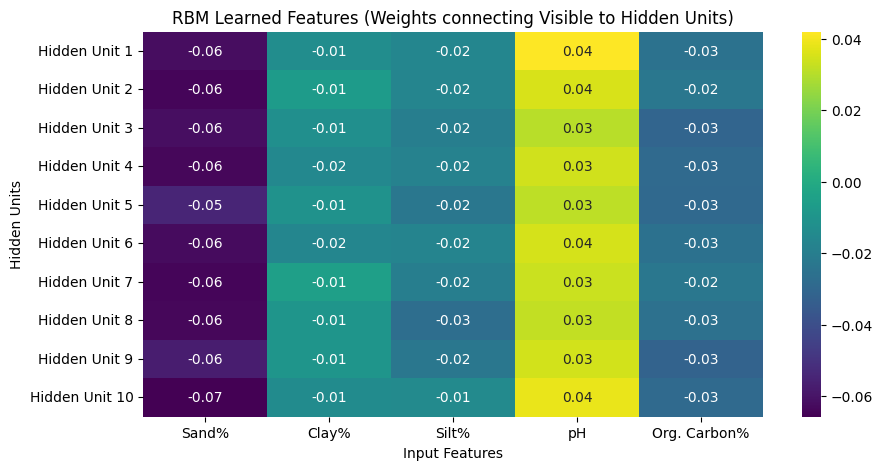


Shape of training data after RBM transformation: (1050, 10)


In [97]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import BernoulliRBM
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Prepare Data ---
# For demonstration, let's create some dummy soil data.
# In a real scenario, you'd load from a CSV, acquire from ISRIC, FAO, etc.
# Assume you have features like sand%, clay%, pH, organic_carbon% and a 'soil_type' label.

# Example numerical features for different soil types
# Let's say: 0: Clay Loam, 1: Sandy Clay, 2: Silt Loam
np.random.seed(42)
num_samples = 500

# Clay Loam characteristics
clay_loam_X = np.column_stack([
    np.random.normal(30, 5, num_samples),  # Sand %
    np.random.normal(35, 5, num_samples),  # Clay %
    np.random.normal(35, 5, num_samples),  # Silt %
    np.random.normal(6.5, 0.5, num_samples), # pH
    np.random.normal(2.5, 0.5, num_samples)  # Organic Carbon %
])
clay_loam_y = np.zeros(num_samples)

# Sandy Clay characteristics
sandy_clay_X = np.column_stack([
    np.random.normal(60, 8, num_samples),  # Sand %
    np.random.normal(30, 5, num_samples),  # Clay %
    np.random.normal(10, 3, num_samples),  # Silt %
    np.random.normal(6.0, 0.7, num_samples), # pH
    np.random.normal(1.0, 0.3, num_samples)  # Organic Carbon %
])
sandy_clay_y = np.ones(num_samples)

# Silt Loam characteristics
silt_loam_X = np.column_stack([
    np.random.normal(20, 4, num_samples),  # Sand %
    np.random.normal(15, 3, num_samples),  # Clay %
    np.random.normal(65, 7, num_samples),  # Silt %
    np.random.normal(7.0, 0.4, num_samples), # pH
    np.random.normal(3.0, 0.6, num_samples)  # Organic Carbon %
])
silt_loam_y = np.full(num_samples, 2)

X = np.vstack([clay_loam_X, sandy_clay_X, silt_loam_X])
y = np.hstack([clay_loam_y, sandy_clay_y, silt_loam_y])

# Shuffle and split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

# Preprocessing: Scale features. RBMs often work well with inputs scaled to [0, 1].
# If your data is binary, BernoulliRBM is suitable. If continuous, you might need
# to discretize or consider GaussianRBM (not directly in sklearn, often custom).
# For general continuous features, MinMaxScaler or StandardScaler can be used.
scaler = MinMaxScaler() # Or StandardScaler() if data distribution is Gaussian-like
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 2. Build the RBM-based Classification Pipeline ---

# Define the RBM
# n_components: Number of hidden units (features RBM will learn)
# learning_rate: How much to adjust weights during training
# n_iter: Number of epochs for training
# verbose: Print progress during training
rbm = BernoulliRBM(n_components=10, learning_rate=0.01, n_iter=20, random_state=42, verbose=True)

# Define the Classifier (e.g., Logistic Regression)
logistic = LogisticRegression(solver='lbfgs', max_iter=200, random_state=42)

# Create a pipeline: RBM for feature extraction, then Logistic Regression for classification
# The RBM is trained unsupervised on the input, and then its transformed output
# (the activations of its hidden units) are fed to the Logistic Regression.
rbm_classifier_pipeline = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

# --- 3. Train the Model ---
print("\nTraining RBM-Logistic Pipeline...")
rbm_classifier_pipeline.fit(X_train_scaled, y_train)
print("Training complete.")

# --- 4. Evaluate the Model ---
print("\nEvaluating RBM-Logistic Pipeline...")
y_pred_rbm = rbm_classifier_pipeline.predict(X_test_scaled)

print("\n--- RBM + Logistic Regression Results ---")
print(classification_report(y_test, y_pred_rbm, target_names=['Clay Loam', 'Sandy Clay', 'Silt Loam']))
print(f"Accuracy with RBM features: {accuracy_score(y_test, y_pred_rbm):.4f}")

# --- 5. (Optional) Compare with a classifier without RBM ---
print("\n--- Baseline: Logistic Regression without RBM ---")
logistic_baseline = LogisticRegression(solver='lbfgs', max_iter=200, random_state=42)
logistic_baseline.fit(X_train_scaled, y_train)
y_pred_baseline = logistic_baseline.predict(X_test_scaled)
print(classification_report(y_test, y_pred_baseline, target_names=['Clay Loam', 'Sandy Clay', 'Silt Loam']))
print(f"Accuracy without RBM features: {accuracy_score(y_test, y_pred_baseline):.4f}")

# --- 6. Visualize RBM learned features (if applicable and interpretable) ---
# For demonstration purposes, let's visualize the weights from visible to hidden layer for the RBM.
# This is more meaningful if your input features have a spatial arrangement (e.g., image pixels).
# For generic tabular data, it's harder to interpret directly.

# If you had 2D image data as input (e.g., 28x28 digits) and n_components for RBM,
# you could reshape rbm.components_ to visualize filters.
# For our 5 features, we can visualize the weights connecting each input feature to each hidden unit.
print("\nVisualizing RBM Components (Weights from Visible to Hidden Units):")
plt.figure(figsize=(10, 5))
sns.heatmap(rbm.components_, cmap='viridis', annot=True, fmt=".2f",
            xticklabels=['Sand%', 'Clay%', 'Silt%', 'pH', 'Org. Carbon%'],
            yticklabels=[f'Hidden Unit {i+1}' for i in range(rbm.n_components)])
plt.title('RBM Learned Features (Weights connecting Visible to Hidden Units)')
plt.xlabel('Input Features')
plt.ylabel('Hidden Units')
plt.show()

# You can also transform the training data using the RBM to see the new feature space
X_train_transformed = rbm.transform(X_train_scaled)
print(f"\nShape of training data after RBM transformation: {X_train_transformed.shape}")

# You could then visualize these transformed features if they are low-dimensional.
# For example, using PCA or t-SNE on X_train_transformed and coloring by y_train
# to see if the RBM created a more separable feature space.

**RBM Demonstration**


**Step-by-Step Explanation and Solution**

 Imports

In [141]:
from __future__ import print_function # Ensures print behaves as a function in Python 2/3 compatible code
import numpy as np # Fundamental package for numerical operations (arrays, matrices)
from sklearn.linear_model import LogisticRegression # Supervised classifier
from sklearn.model_selection import train_test_split # Utility for splitting data into train/test sets
from sklearn.metrics import classification_report, accuracy_score # Metrics for evaluating classifier performance
from sklearn.preprocessing import MinMaxScaler # Preprocessing tool to scale features to a [0, 1] range

RBM Class Definition

In [142]:
class RBM:
    def __init__(self, num_visible, num_hidden):
        self.num_hidden = num_hidden
        self.num_visible = num_visible
        self.debug_print = True # Flag to control verbose output during training

        np_rng = np.random.RandomState(1234) # Seeded random number generator for reproducibility

        # Initialize weights between visible and hidden units
        # Glorot (Xavier) initialization heuristic: scaled uniform distribution
        self.weights = np.asarray(np_rng.uniform(
                            low=-0.1 * np.sqrt(6. / (num_hidden + num_visible)),
                            high=0.1 * np.sqrt(6. / (num_hidden + num_visible)),
                            size=(num_visible, num_hidden)))

        # Insert rows/columns of zeros to accommodate bias units.
        # self.weights[0, 1:] will store hidden unit biases.
        # self.weights[1:, 0] will store visible unit biases.
        self.weights = np.insert(self.weights, 0, 0, axis = 0) # Add row for hidden biases
        self.weights = np.insert(self.weights, 0, 0, axis = 1) # Add column for visible biases

    def train(self, data, max_epochs = 1000, learning_rate = 0.1):
            num_examples = data.shape[0]
            # Add a bias column (all ones) to the input data for interaction with visible biases
            data = np.insert(data, 0, 1, axis = 1)

            for epoch in range(max_epochs):
                # --- Positive Phase (Reality) ---
                # Calculate activation of hidden units given visible data
                pos_hidden_activations = np.dot(data, self.weights)
                # Convert activations to probabilities using sigmoid
                pos_hidden_probs = self._logistic(pos_hidden_activations)
                # Fix the bias unit for hidden layer to 1 (its probability is always 1)
                pos_hidden_probs[:,0] = 1
                # Sample binary hidden states from probabilities
                pos_hidden_states = pos_hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)
                # Calculate positive associations (outer product of visible data and hidden probabilities)
                pos_associations = np.dot(data.T, pos_hidden_probs)

                # --- Negative Phase (Daydreaming / Reconstruction) ---
                # Reconstruct visible units from sampled positive hidden states
                neg_visible_activations = np.dot(pos_hidden_states, self.weights.T)
                # Convert reconstructed visible activations to probabilities
                neg_visible_probs = self._logistic(neg_visible_activations)
                # Fix the bias unit for visible layer to 1
                neg_visible_probs[:,0] = 1
                # Sample hidden units from reconstructed visible probabilities
                neg_hidden_activations = np.dot(neg_visible_probs, self.weights)
                # Convert to probabilities
                neg_hidden_probs = self._logistic(neg_hidden_activations)
                # Calculate negative associations
                neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

                # --- Weight Update (Contrastive Divergence gradient) ---
                # Adjust weights to increase positive associations and decrease negative associations
                self.weights += learning_rate * ((pos_associations - neg_associations) / num_examples)

                # Calculate reconstruction error for monitoring
                error = np.sum((data - neg_visible_probs) ** 2)
                if self.debug_print:
                    # Print error periodically
                    if epoch % (max_epochs // 10) == 0 or epoch == max_epochs -1:
                        print("Epoch %s: error is %s" % (epoch, error))

    def run_visible(self, data):
            num_examples = data.shape[0]
            # Initialize hidden states matrix (with a column for bias)
            hidden_states = np.ones((num_examples, self.num_hidden + 1))
            # Add bias column to input data
            data = np.insert(data, 0, 1, axis = 1)

            # Calculate activations and probabilities of hidden units
            hidden_activations = np.dot(data, self.weights)
            hidden_probs = self._logistic(hidden_activations)
            # Sample binary hidden states (this is the RBM's "feature vector")
            hidden_states[:,:] = hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)

            # Return hidden states, excluding the bias unit
            hidden_states = hidden_states[:,1:]
            return hidden_states

    def run_hidden(self, data):
            num_examples = data.shape[0]
            # Initialize visible states matrix (with a column for bias)
            visible_states = np.ones((num_examples, self.num_visible + 1))
            # Add bias column to input data (which are now hidden states)
            data = np.insert(data, 0, 1, axis = 1)

            # Calculate activations and probabilities of visible units
            visible_activations = np.dot(data, self.weights.T) # Use transpose of weights
            visible_probs = self._logistic(visible_activations)
            # Sample binary visible states
            visible_states[:,:] = visible_probs > np.random.rand(num_examples, self.num_visible + 1)

            # Return visible states, excluding the bias unit
            visible_states = visible_states[:,1:]
            return visible_states

    def daydream(self, num_samples):
            samples = np.ones((num_samples, self.num_visible + 1))
            # Initialize the first sample randomly
            samples[0,1:] = np.random.rand(self.num_visible)

            # Perform alternating Gibbs sampling
            for i in range(1, num_samples):
                visible = samples[i-1,:] # Start with the previous visible sample

                # 1. Sample hidden units from current visible
                hidden_activations = np.dot(visible, self.weights)
                hidden_probs = self._logistic(hidden_activations)
                hidden_states = hidden_probs > np.random.rand(self.num_hidden + 1)
                hidden_states[0] = 1 # Fix hidden bias unit

                # 2. Sample visible units from current hidden
                visible_activations = np.dot(hidden_states, self.weights.T)
                visible_probs = self._logistic(visible_activations)
                visible_states = visible_probs > np.random.rand(self.num_visible + 1)
                samples[i,:] = visible_states # Store the new visible sample

            # Return generated visible samples, excluding bias
            return samples[:,1:]

    def _logistic(self, x):
            return 1.0 / (1 + np.exp(-x))

train(self, data, max_epochs = 1000, learning_rate = 0.1): Training the RBM

In [143]:
def train(self, data, max_epochs = 1000, learning_rate = 0.1):
        num_examples = data.shape[0]
        # Add a bias column (all ones) to the input data for interaction with visible biases
        data = np.insert(data, 0, 1, axis = 1)

        for epoch in range(max_epochs):
            # --- Positive Phase (Reality) ---
            # Calculate activation of hidden units given visible data
            pos_hidden_activations = np.dot(data, self.weights)
            # Convert activations to probabilities using sigmoid
            pos_hidden_probs = self._logistic(pos_hidden_activations)
            # Fix the bias unit for hidden layer to 1 (its probability is always 1)
            pos_hidden_probs[:,0] = 1
            # Sample binary hidden states from probabilities
            pos_hidden_states = pos_hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)
            # Calculate positive associations (outer product of visible data and hidden probabilities)
            pos_associations = np.dot(data.T, pos_hidden_probs)

            # --- Negative Phase (Daydreaming / Reconstruction) ---
            # Reconstruct visible units from sampled positive hidden states
            neg_visible_activations = np.dot(pos_hidden_states, self.weights.T)
            # Convert reconstructed visible activations to probabilities
            neg_visible_probs = self._logistic(neg_visible_activations)
            # Fix the bias unit for visible layer to 1
            neg_visible_probs[:,0] = 1
            # Sample hidden units from reconstructed visible probabilities
            neg_hidden_activations = np.dot(neg_visible_probs, self.weights)
            # Convert to probabilities
            neg_hidden_probs = self._logistic(neg_hidden_activations)
            # Calculate negative associations
            neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

            # --- Weight Update (Contrastive Divergence gradient) ---
            # Adjust weights to increase positive associations and decrease negative associations
            self.weights += learning_rate * ((pos_associations - neg_associations) / num_examples)

            # Calculate reconstruction error for monitoring
            error = np.sum((data - neg_visible_probs) ** 2)
            if self.debug_print:
                # Print error periodically
                if epoch % (max_epochs // 10) == 0 or epoch == max_epochs -1:
                    print("Epoch %s: error is %s" % (epoch, error))

run_visible(self, data): Forward Pass (Feature Extraction)

In [144]:
def run_visible(self, data):
        num_examples = data.shape[0]
        # Initialize hidden states matrix (with a column for bias)
        hidden_states = np.ones((num_examples, self.num_hidden + 1))
        # Add bias column to input data
        data = np.insert(data, 0, 1, axis = 1)

        # Calculate activations and probabilities of hidden units
        hidden_activations = np.dot(data, self.weights)
        hidden_probs = self._logistic(hidden_activations)
        # Sample binary hidden states (this is the RBM's "feature vector")
        hidden_states[:,:] = hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)

        # Return hidden states, excluding the bias unit
        hidden_states = hidden_states[:,1:]
        return hidden_states

run_hidden(self, data): Backward Pass (Reconstruction)

In [145]:
def run_hidden(self, data):
        num_examples = data.shape[0]
        # Initialize visible states matrix (with a column for bias)
        visible_states = np.ones((num_examples, self.num_visible + 1))
        # Add bias column to input data (which are now hidden states)
        data = np.insert(data, 0, 1, axis = 1)

        # Calculate activations and probabilities of visible units
        visible_activations = np.dot(data, self.weights.T) # Use transpose of weights
        visible_probs = self._logistic(visible_activations)
        # Sample binary visible states
        visible_states[:,:] = visible_probs > np.random.rand(num_examples, self.num_visible + 1)

        # Return visible states, excluding the bias unit
        visible_states = visible_states[:,1:]
        return visible_states

daydream(self, num_samples): Generative Sampling (Gibbs)

In [146]:
def daydream(self, num_samples):
        samples = np.ones((num_samples, self.num_visible + 1))
        # Initialize the first sample randomly
        samples[0,1:] = np.random.rand(self.num_visible)

        # Perform alternating Gibbs sampling
        for i in range(1, num_samples):
            visible = samples[i-1,:] # Start with the previous visible sample

            # 1. Sample hidden units from current visible
            hidden_activations = np.dot(visible, self.weights)
            hidden_probs = self._logistic(hidden_activations)
            hidden_states = hidden_probs > np.random.rand(self.num_hidden + 1)
            hidden_states[0] = 1 # Fix hidden bias unit

            # 2. Sample visible units from current hidden
            visible_activations = np.dot(hidden_states, self.weights.T)
            visible_probs = self._logistic(visible_activations)
            visible_states = visible_probs > np.random.rand(self.num_visible + 1)
            samples[i,:] = visible_states # Store the new visible sample

        # Return generated visible samples, excluding bias
        return samples[:,1:]

_logistic(self, x): Sigmoid Activation

In [147]:
def _logistic(self, x):
        return 1.0 / (1 + np.exp(-x))

Main Execution Block (if __name__ == '__main__':)

In [148]:
if __name__ == '__main__':
    print("--- RBM Demonstration ---")

    # Define the RBM with 6 visible units (features) and 2 hidden units
    rbm = RBM(num_visible=6, num_hidden=2)

    # --- Dataset for Soil Classification Analogy ---
    # Imagine 6 binary features representing soil characteristics:
    # F1: High Sand, F2: High Clay, F3: High Silt, F4: Acidic pH, F5: Alkaline pH, F6: High Organic Matter
    # Soil Type A (e.g., Sandy Loam): F1, F3, F6 are often 'on' (1)
    # Soil Type B (e.g., Clayey Soil): F2, F5, F6 are often 'on' (1)

    # Creating a synthetic dataset with labels for classification
    # Each row is a soil sample, last column is the label (0 for Type A, 1 for Type B)
    soil_data = np.array([
        # Soil Type A examples (Sandy Loam)
        [1, 0, 1, 1, 0, 1, 0], # Sample 1
        [1, 0, 1, 0, 0, 1, 0], # Sample 2
        [1, 0, 1, 1, 0, 0, 0], # Sample 3 (less organic matter)
        [1, 0, 0, 1, 0, 1, 0], # Sample 4 (less silt, still sandy loam)
        [0, 0, 1, 1, 0, 1, 0], # Sample 5 (more silt than sand, but still Type A characteristic)

        # Soil Type B examples (Clayey Soil)
        [0, 1, 0, 0, 1, 1, 1], # Sample 6
        [0, 1, 0, 0, 1, 0, 1], # Sample 7 (less organic matter)
        [0, 1, 0, 0, 0, 1, 1], # Sample 8 (less alkaline pH, but still clayey)
        [0, 1, 1, 0, 1, 1, 1], # Sample 9 (some silt, but dominated by clay)
        [0, 1, 0, 0, 1, 1, 1]  # Sample 10
    ])

    # Separate features (X) and labels (y)
    X = soil_data[:, :-1] # All columns except the last one
    y = soil_data[:, -1]  # The last column is the label

    # Preprocessing: Scale data. RBMs generally perform better with scaled inputs.
    # For binary data, MinMaxScaler might not change much if it's already 0/1,
    # but it's good practice for potentially continuous values.
    scaler = MinMaxScaler()
    X_scaled_local = scaler.fit_transform(X) # Scale X features to [0, 1] using a local variable name

    # Split data into training and testing sets
    # stratify=y ensures that the proportion of classes is the same in train/test splits
    X_train_local, X_test_local, y_train_local, y_test_local = train_test_split(X_scaled_local, y, test_size=0.3, random_state=42, stratify=y)

    print(f"\nOriginal X_train shape: {X_train_local.shape}")
    print(f"Original X_test shape: {X_test_local.shape}")

    # --- Step 1: Train the RBM (unsupervised feature learning) ---
    print("\n--- Training RBM for feature learning ---")
    # The RBM is trained ONLY on the features (X_train_local), without using the labels (y_train_local).
    # This is the unsupervised pre-training step.
    rbm.train(X_train_local, max_epochs=5000, learning_rate=0.01) # Reduced learning rate for stability

    print("\n--- Learned RBM Weights (Visible x Hidden + Biases) ---")
    # Print the full learned weight matrix, including the bias terms.
    print(rbm.weights)

    # --- Step 2: Use the trained RBM to transform data into a new feature space ---
    print("\n--- Transforming data using trained RBM (feature extraction) ---")
    # Transform both training and testing data using the RBM's run_visible method.
    # This converts original features into the RBM's hidden unit activations.
    X_train_transformed = rbm.run_visible(X_train_local)
    X_test_transformed = rbm.run_visible(X_test_local)

    print(f"Transformed X_train shape (RBM features): {X_train_transformed.shape}")
    print(f"Transformed X_test shape (RBM features): {X_test_transformed.shape}")
    print("\nExample of RBM-transformed features (first 5 training samples):")
    print(X_train_transformed[:5]) # Display some of the new features

    # --- Step 3: Train a supervised classifier on the RBM-transformed features ---
    print("\n--- Training Logistic Regression on RBM features ---")
    # Instantiate and train a Logistic Regression model on the new RBM features and original labels.
    classifier = LogisticRegression(solver='liblinear', random_state=42, max_iter=200)
    classifier.fit(X_train_transformed, y_train_local) # Use local y_train_local

    # --- Step 4: Evaluate the classifier ---
    print("\n--- Evaluation on RBM-transformed features ---")
    # Make predictions on the transformed test set.
    y_pred = classifier.predict(X_test_transformed)
    # Print accuracy and a detailed classification report.
    print(f"Accuracy: {accuracy_score(y_test_local, y_pred):.4f}") # Use local y_test_local
    print("\nClassification Report:")
    print(classification_report(y_test_local, y_pred, target_names=['Soil Type A', 'Soil Type B'])) # Use local y_test_local

    # --- Compare with a baseline (Logistic Regression on original features) ---
    print("\n--- Baseline: Training Logistic Regression on ORIGINAL features ---")
    # Train a Logistic Regression model directly on the original scaled features for comparison.
    baseline_classifier = LogisticRegression(solver='liblinear', random_state=42, max_iter=200)
    # Explicitly use the local variables here
    baseline_classifier.fit(X_train_local, y_train_local)
    y_pred_baseline = baseline_classifier.predict(X_test_local)

    print(f"Baseline Accuracy (original features): {accuracy_score(y_test_local, y_pred_baseline):.4f}")
    print("\nBaseline Classification Report:")
    print(classification_report(y_test_local, y_pred_baseline, target_names=['Soil Type A', 'Soil Type B']))

    # --- Daydreaming Example (Generative Capability) ---
    print("\n--- Daydreaming (Generating new visible samples) ---")
    # Use the RBM's generative capability to produce new samples.
    generated_samples = rbm.daydream(num_samples=5) # Generate 5 new samples
    print("Generated 5 new binary soil patterns (excluding bias):")
    # Round to int and cast for clearer binary representation
    print(np.round(generated_samples).astype(int))

--- RBM Demonstration ---

Original X_train shape: (7, 6)
Original X_test shape: (3, 6)

--- Training RBM for feature learning ---
Epoch 0: error is 10.549020105058661
Epoch 500: error is 9.08806509500713
Epoch 1000: error is 9.975885596524034
Epoch 1500: error is 7.341255537240186
Epoch 2000: error is 5.700609053893077
Epoch 2500: error is 5.797961862057911
Epoch 3000: error is 4.921821354722249
Epoch 3500: error is 4.743215328259206
Epoch 4000: error is 4.632563018091656
Epoch 4500: error is 4.376864789345284
Epoch 4999: error is 4.502113583624657

--- Learned RBM Weights (Visible x Hidden + Biases) ---
[[ 3.52769441  0.16529987  0.16791533]
 [ 0.52123652 -2.41784138 -2.34178333]
 [-1.33255605  2.44818343  2.55560937]
 [ 2.72770102 -1.87595279 -2.14702944]
 [ 0.51726732 -2.41937234 -2.31120867]
 [-1.6991731   1.475193    1.40775278]
 [ 1.0761157   0.03444665 -0.02728793]]

--- Transforming data using trained RBM (feature extraction) ---
Transformed X_train shape (RBM features): (7, 2

Main Execution Block (if __name__ == '__main__':)

In [149]:
if __name__ == '__main__':
    print("--- RBM Demonstration ---")

    # Define the RBM with 6 visible units (features) and 2 hidden units
    rbm = RBM(num_visible=6, num_hidden=2)

    # --- Dataset for Soil Classification Analogy ---
    # Imagine 6 binary features representing soil characteristics:
    # F1: High Sand, F2: High Clay, F3: High Silt, F4: Acidic pH, F5: Alkaline pH, F6: High Organic Matter
    # Soil Type A (e.g., Sandy Loam): F1, F3, F6 are often 'on' (1)
    # Soil Type B (e.g., Clayey Soil): F2, F5, F6 are often 'on' (1)

    # Creating a synthetic dataset with labels for classification
    # Each row is a soil sample, last column is the label (0 for Type A, 1 for Type B)
    soil_data = np.array([
        # Soil Type A examples (Sandy Loam)
        [1, 0, 1, 1, 0, 1, 0], # Sample 1
        [1, 0, 1, 0, 0, 1, 0], # Sample 2
        [1, 0, 1, 1, 0, 0, 0], # Sample 3 (less organic matter)
        [1, 0, 0, 1, 0, 1, 0], # Sample 4 (less silt, still sandy loam)
        [0, 0, 1, 1, 0, 1, 0], # Sample 5 (more silt than sand, but still Type A characteristic)

        # Soil Type B examples (Clayey Soil)
        [0, 1, 0, 0, 1, 1, 1], # Sample 6
        [0, 1, 0, 0, 1, 0, 1], # Sample 7 (less organic matter)
        [0, 1, 0, 0, 0, 1, 1], # Sample 8 (less alkaline pH, but still clayey)
        [0, 1, 1, 0, 1, 1, 1], # Sample 9 (some silt, but dominated by clay)
        [0, 1, 0, 0, 1, 1, 1]  # Sample 10
    ])

    # Separate features (X) and labels (y)
    X = soil_data[:, :-1] # All columns except the last one
    y = soil_data[:, -1]  # The last column is the label

    # Preprocessing: Scale data. RBMs generally perform better with scaled inputs.
    # For binary data, MinMaxScaler might not change much if it's already 0/1,
    # but it's good practice for potentially continuous values.
    scaler = MinMaxScaler()
    X_scaled_local = scaler.fit_transform(X) # Scale X features to [0, 1] using a local variable name

    # Split data into training and testing sets
    # stratify=y ensures that the proportion of classes is the same in train/test splits
    X_train_local, X_test_local, y_train_local, y_test_local = train_test_split(X_scaled_local, y, test_size=0.3, random_state=42, stratify=y)

    print(f"\nOriginal X_train shape: {X_train_local.shape}")
    print(f"Original X_test shape: {X_test_local.shape}")

    # --- Step 1: Train the RBM (unsupervised feature learning) ---
    print("\n--- Training RBM for feature learning ---")
    # The RBM is trained ONLY on the features (X_train_local), without using the labels (y_train_local).
    # This is the unsupervised pre-training step.
    rbm.train(X_train_local, max_epochs=5000, learning_rate=0.01) # Reduced learning rate for stability

    print("\n--- Learned RBM Weights (Visible x Hidden + Biases) ---")
    # Print the full learned weight matrix, including the bias terms.
    print(rbm.weights)

    # --- Step 2: Use the trained RBM to transform data into a new feature space ---
    print("\n--- Transforming data using trained RBM (feature extraction) ---")
    # Transform both training and testing data using the RBM's run_visible method.
    # This converts original features into the RBM's hidden unit activations.
    X_train_transformed = rbm.run_visible(X_train_local)
    X_test_transformed = rbm.run_visible(X_test_local)

    print(f"Transformed X_train shape (RBM features): {X_train_transformed.shape}")
    print(f"Transformed X_test shape (RBM features): {X_test_transformed.shape}")
    print("\nExample of RBM-transformed features (first 5 training samples):")
    print(X_train_transformed[:5]) # Display some of the new features

    # --- Step 3: Train a supervised classifier on the RBM-transformed features ---
    print("\n--- Training Logistic Regression on RBM features ---")
    # Instantiate and train a Logistic Regression model on the new RBM features and original labels.
    classifier = LogisticRegression(solver='liblinear', random_state=42, max_iter=200)
    classifier.fit(X_train_transformed, y_train_local) # Use local y_train_local

    # --- Step 4: Evaluate the classifier ---
    print("\n--- Evaluation on RBM-transformed features ---")
    # Make predictions on the transformed test set.
    y_pred = classifier.predict(X_test_transformed)
    # Print accuracy and a detailed classification report.
    print(f"Accuracy: {accuracy_score(y_test_local, y_pred):.4f}") # Use local y_test_local
    print("\nClassification Report:")
    print(classification_report(y_test_local, y_pred, target_names=['Soil Type A', 'Soil Type B'])) # Use local y_test_local

    # --- Compare with a baseline (Logistic Regression on original features) ---
    print("\n--- Baseline: Training Logistic Regression on ORIGINAL features ---")
    # Train a Logistic Regression model directly on the original scaled features for comparison.
    baseline_classifier = LogisticRegression(solver='liblinear', random_state=42, max_iter=200)
    # Explicitly use the local variables here
    baseline_classifier.fit(X_train_local, y_train_local)
    y_pred_baseline = baseline_classifier.predict(X_test_local)

    print(f"Baseline Accuracy (original features): {accuracy_score(y_test_local, y_pred_baseline):.4f}")
    print("\nBaseline Classification Report:")
    print(classification_report(y_test_local, y_pred_baseline, target_names=['Soil Type A', 'Soil Type B']))

    # --- Daydreaming Example (Generative Capability) ---
    print("\n--- Daydreaming (Generating new visible samples) ---")
    # Use the RBM's generative capability to produce new samples.
    generated_samples = rbm.daydream(num_samples=5) # Generate 5 new samples
    print("Generated 5 new binary soil patterns (excluding bias):")
    # Round to int and cast for clearer binary representation
    print(np.round(generated_samples).astype(int))

--- RBM Demonstration ---

Original X_train shape: (7, 6)
Original X_test shape: (3, 6)

--- Training RBM for feature learning ---
Epoch 0: error is 10.47801484114422
Epoch 500: error is 9.508948285388309
Epoch 1000: error is 8.696184556659569
Epoch 1500: error is 7.149271123580132
Epoch 2000: error is 7.035261587158553
Epoch 2500: error is 6.762974573882682
Epoch 3000: error is 5.071938579636706
Epoch 3500: error is 5.389176111466112
Epoch 4000: error is 5.266269306330922
Epoch 4500: error is 4.557381516088263
Epoch 4999: error is 4.500483929228848

--- Learned RBM Weights (Visible x Hidden + Biases) ---
[[ 3.52826708  0.17068702  0.17082571]
 [ 0.51497538 -2.41016786 -2.33465994]
 [-1.32889393  2.43815481  2.54416858]
 [ 2.73610693 -1.85582063 -2.12873775]
 [ 0.51101811 -2.4116801  -2.30405104]
 [-1.70288428  1.46351075  1.39550992]
 [ 1.07553218  0.03675306 -0.02687502]]

--- Transforming data using trained RBM (feature extraction) ---
Transformed X_train shape (RBM features): (7, 2